In [12]:
# acoustic solver

In [13]:
# GPU

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
# ------------------------------
# 1. mesh
# ------------------------------
def generate_mesh(nx, ny, Lx=1.0, Ly=1.0):
    x = jnp.linspace(0, Lx, nx + 1)
    y = jnp.linspace(0, Ly, ny + 1)
    X, Y = jnp.meshgrid(x, y, indexing='xy')
    nodes = jnp.vstack([X.ravel(), Y.ravel()]).T


    elements_list = []
    for j in range(ny):
        for i in range(nx):
            n1 = j * (nx + 1) + i
            n2 = n1 + 1
            n3 = n1 + (nx + 1)
            n4 = n3 + 1
            elements_list.append([n1, n2, n4])
            elements_list.append([n1, n4, n3])
    elements = jnp.array(elements_list, dtype=jnp.int32)
    return nodes, elements

# ------------------------------
# 2. local matrix
# ------------------------------
def element_matrices(coords):
    x1, y1 = coords[0]
    x2, y2 = coords[1]
    x3, y3 = coords[2]
    area = 0.5 * jnp.abs((x2 - x1) * (y3 - y1) - (x3 - x1) * (y2 - y1))
    b = jnp.array([y2 - y3, y3 - y1, y1 - y2])
    c = jnp.array([x3 - x2, x1 - x3, x2 - x1])
    Ke = (1.0 / (4.0 * area)) * (jnp.outer(b, b) + jnp.outer(c, c))
    Me = (area / 12.0) * jnp.array([[2, 1, 1],
                                    [1, 2, 1],
                                    [1, 1, 2]])
    return Ke, Me

# ------------------------------
# 3. global matrix
# ------------------------------
def assemble_global_matrices_vmap(nodes, elements, k,  control=1.0, Ly=1.0, rng_key=None):
    num_nodes = nodes.shape[0]
    num_elems = elements.shape[0]
    if rng_key is None:
        rng_key = jax.random.PRNGKey(0)
    # ----------------------------------------------------------------
    elem_coords = nodes[elements]  
    

    x1 = elem_coords[:, 0, 0]
    y1 = elem_coords[:, 0, 1]
    x2 = elem_coords[:, 1, 0]
    y2 = elem_coords[:, 1, 1]
    x3 = elem_coords[:, 2, 0]
    y3 = elem_coords[:, 2, 1]
    areas = 0.5 * jnp.abs((x2 - x1) * (y3 - y1) - (x3 - x1) * (y2 - y1))  # (E,)
    

    b = jnp.stack([y2 - y3, y3 - y1, y1 - y2], axis=1)
    c = jnp.stack([x3 - x2, x1 - x3, x2 - x1], axis=1)
    

    def local_Ke(b_row, c_row, area):
        return (1.0 / (4.0 * area)) * (jnp.outer(b_row, b_row) + jnp.outer(c_row, c_row))
    local_Ke_all = jax.vmap(local_Ke)(b, c, areas)  # shape (E, 3, 3)

    Me_const = jnp.array([[2, 1, 1],
                           [1, 2, 1],
                           [1, 1, 2]], dtype=jnp.float32)
    # local mass matrix: (area / 12)*Me_const
    local_Me_all = (areas / 12.0)[:, None, None] * Me_const  # shape (E, 3, 3)

    ## ================================= choose this or the below
    ## 6. random m N(0, 0.04)
    #random_ms = jax.random.normal(rng_key, shape=(num_elems,), dtype=jnp.float32) * jnp.sqrt(0.04)
    #factors = jnp.exp(2 * random_ms * control)  # shape (E,)
    #local_M_mod_all = factors[:, None, None] * local_Me_all  # shape (E, 3, 3)
    ## ================================= choose this or the above
    # define linear medium 
    centers = jnp.mean(elem_coords, axis=1)
    m_vals = 1/Ly * centers[:, 0] + 0.0 * centers[:, 1]  #  (num_elems,)
    factors = jnp.exp(2 * m_vals * control)  # shape (num_elems,)
    local_M_mod_all = factors[:, None, None] * local_Me_all  # shape (E, 3, 3)
    # =================================
    

    global_K = jnp.zeros((num_nodes, num_nodes), dtype=jnp.float32)
    global_M_mod = jnp.zeros((num_nodes, num_nodes), dtype=jnp.float32)
    
    elem_rows = jnp.broadcast_to(elements[:, :, None], local_Ke_all.shape)  # (E, 3, 3)
    elem_cols = jnp.broadcast_to(elements[:, None, :], local_Ke_all.shape)  # (E, 3, 3)
    
    flat_rows = elem_rows.reshape(-1)
    flat_cols = elem_cols.reshape(-1)
    flat_Ke = local_Ke_all.reshape(-1)
    flat_M_mod = local_M_mod_all.reshape(-1)
    
    global_K = global_K.at[(flat_rows, flat_cols)].add(flat_Ke)
    global_M_mod = global_M_mod.at[(flat_rows, flat_cols)].add(flat_M_mod)
    
    global_A = global_K - (k ** 2) * global_M_mod
    global_f = jnp.zeros(num_nodes, dtype=jnp.complex64)
    return global_A, global_f

# ------------------------------
# 4. boundary condition
# ------------------------------
def apply_pml_bc(A, nodes, nx, ny, k, Lx=1.0, Ly=1.0):
    tol = 1e-10
    def edge_mass(length):
        return (length / 6.0) * jnp.array([[2, 1],
                                           [1, 2]])
    A_arr = A
    # --- bot： y = 0 ---
    for i in range(nx):
        idx1 = i
        idx2 = i + 1
        length = jnp.linalg.norm(nodes[idx2] - nodes[idx1])
        m_edge = edge_mass(length)
        A_arr = A_arr.at[idx1, idx1].add(-1j * k * m_edge[0, 0])
        A_arr = A_arr.at[idx1, idx2].add(-1j * k * m_edge[0, 1])
        A_arr = A_arr.at[idx2, idx1].add(-1j * k * m_edge[1, 0])
        A_arr = A_arr.at[idx2, idx2].add(-1j * k * m_edge[1, 1])
    # --- left： x = 0 ---
    for j in range(ny):
        idx1 = j * (nx + 1)
        idx2 = (j + 1) * (nx + 1)
        if (nodes[idx1, 1] > Ly - tol) or (nodes[idx2, 1] > Ly - tol):
            continue
        length = jnp.linalg.norm(nodes[idx2] - nodes[idx1])
        m_edge = edge_mass(length)
        A_arr = A_arr.at[idx1, idx1].add(-1j * k * m_edge[0, 0])
        A_arr = A_arr.at[idx1, idx2].add(-1j * k * m_edge[0, 1])
        A_arr = A_arr.at[idx2, idx1].add(-1j * k * m_edge[1, 0])
        A_arr = A_arr.at[idx2, idx2].add(-1j * k * m_edge[1, 1])
    # --- right： x = Lx ---
    for j in range(ny):
        idx1 = j * (nx + 1) + nx
        idx2 = (j + 1) * (nx + 1) + nx
        if (nodes[idx1, 1] > Ly - tol) or (nodes[idx2, 1] > Ly - tol):
            continue
        length = jnp.linalg.norm(nodes[idx2] - nodes[idx1])
        m_edge = edge_mass(length)
        A_arr = A_arr.at[idx1, idx1].add(-1j * k * m_edge[0, 0])
        A_arr = A_arr.at[idx1, idx2].add(-1j * k * m_edge[0, 1])
        A_arr = A_arr.at[idx2, idx1].add(-1j * k * m_edge[1, 0])
        A_arr = A_arr.at[idx2, idx2].add(-1j * k * m_edge[1, 1])
    return A_arr

norm of u: 5.0080957


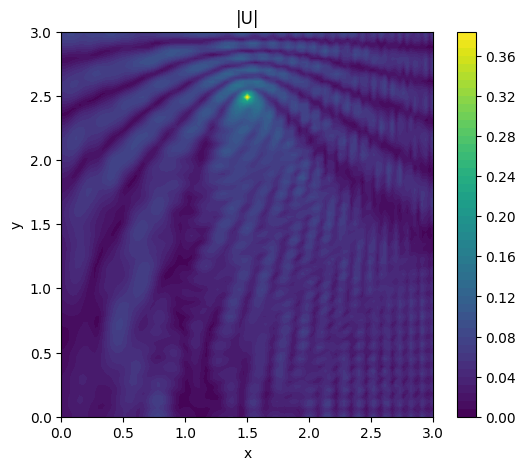

In [5]:
# ------------------------------
# 5. main
# ------------------------------

nx, ny = 100, 100
Lx, Ly = 3.0, 3.0
nodes, elements = generate_mesh(nx, ny, Lx, Ly)

k = 20.0        
rng_key = jax.random.PRNGKey(42)
A, f = assemble_global_matrices_vmap(nodes, elements, k, control=1.0, Ly=Ly, rng_key=rng_key)
A = A.astype(jnp.complex64)

# define source
point_source = jnp.array([1.5, 2.5])#([1.5/2, 2.5/2])
distances = jnp.linalg.norm(nodes - point_source, axis=1)
source_index = int(jnp.argmin(distances))
f = f.at[source_index].set(1.0)

#  boundary condition
A = apply_pml_bc(A, nodes, nx, ny, k, Lx, Ly)

#  A u = f
u = jnp.linalg.solve(A, f)
norm_u = jnp.linalg.norm(u)
print("norm of u:", norm_u)


X = jnp.reshape(nodes[:, 0], (ny + 1, nx + 1))
Y = jnp.reshape(nodes[:, 1], (ny + 1, nx + 1))
u_abs = jnp.reshape(jnp.abs(u), (ny + 1, nx + 1))

X_np = jnp.array(X)
Y_np = jnp.array(Y)
u_abs_np = jnp.array(u_abs)

plt.figure(figsize=(6, 5))
cp = plt.contourf(X_np, Y_np, u_abs_np, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.title('|U|')
plt.xlabel('x')
plt.ylabel('y')

plt.savefig('acoustic_case_show_field_case_3.png',bbox_inches='tight',dpi=300)
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_time_snapshots(u_np, nodes, nx, ny, omega, times):
    X = nodes[:, 0].reshape((ny+1, nx+1))
    Y = nodes[:, 1].reshape((ny+1, nx+1))
    
    n_time = len(times)
    fig, axs = plt.subplots(1, n_time, figsize=(5 * n_time, 4.2))
    if n_time == 1:
        axs = [axs]
    
    for ax, t in zip(axs, times):
        u_t = np.real(u_np * np.exp(-1j * omega * t))
        u_grid = u_t.reshape((ny+1, nx+1))
        
        cp = ax.contourf(X, Y, u_grid, levels=50, cmap='viridis')
        ax.set_title(f't = {t:.2f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        fig.colorbar(cp, ax=ax)
    
    plt.tight_layout()
    

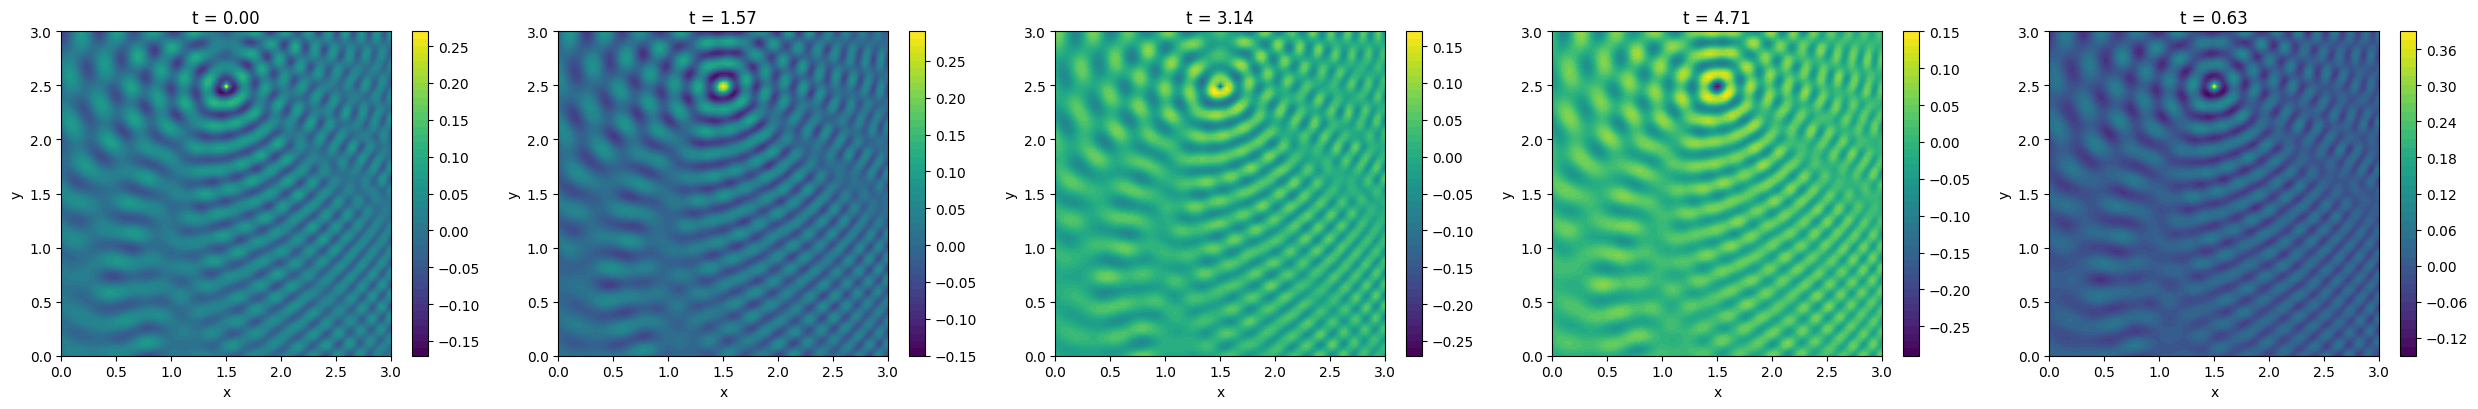

In [7]:
omega = 1.0  
times = jnp.array([0.0, 0.25, 0.50, 0.75, 0.1])*2*jnp.pi/omega 

plot_time_snapshots(u, nodes, nx, ny, omega, times)
plt.savefig('acoustic_case_show_field_case_3_1.png',bbox_inches='tight',dpi=300)

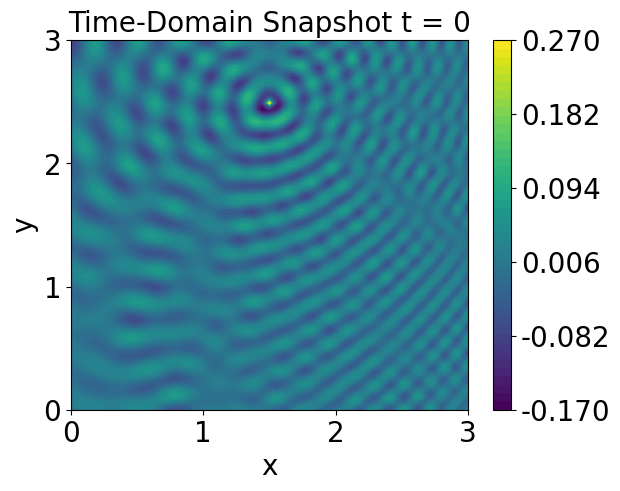

In [9]:
import matplotlib.ticker as ticker

#nx, ny = 100, 100
#Lx, Ly = 3.0, 3.0
nodes, elements = generate_mesh(nx, ny, Lx, Ly)
X = nodes[:, 0].reshape((ny+1, nx+1))
Y = nodes[:, 1].reshape((ny+1, nx+1))

u_t = np.real(u * np.exp(-1j * omega * 0))
u_grid = u_t.reshape((ny+1, nx+1))
fontsize=20
    
cp = plt.contourf(X, Y, u_grid, levels=50, cmap='viridis')
plt.xticks([0,1.0,2.0,3.0],fontsize=fontsize)
plt.yticks([0,1.0,2.0,3.0],fontsize=fontsize)
plt.title(f'Time-Domain Snapshot t = {0}',fontsize=fontsize)
plt.xlabel('x',fontsize=fontsize)
plt.ylabel('y',fontsize=fontsize)
cbar = plt.colorbar(cp)
cbar.ax.tick_params(labelsize=fontsize)  


vmin, vmax = cp.get_clim()  


ticks = np.linspace(vmin, vmax, 6)


cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize=fontsize)

cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.savefig('acoustic_case_show_field_case_3_2.png',bbox_inches='tight',dpi=300)

In [13]:
def sealed_acoustic_solver(design, source_strength, k, rng_key):
    # this function 1, return a whole field, 2, observe a scalar at design in the solved field
    
    nodes, elements = generate_mesh(nx, ny, Lx, Ly)
    
    #rng_key = jax.random.PRNGKey(42)
    A, f = assemble_global_matrices_vmap(nodes, elements, k, Ly=Ly, rng_key=rng_key)
    A = A.astype(jnp.complex64)
    
    point_source = jnp.array([1.5/2, 2.5/2])
    distances = jnp.linalg.norm(nodes - point_source, axis=1)
    source_index = int(jnp.argmin(distances))
    f = f.at[source_index].set(source_strength)
    
    A = apply_pml_bc(A, nodes, nx, ny, k, Lx, Ly)
    
    u = jnp.linalg.solve(A, f).reshape(nx+1, ny+1)

    measure = jax.scipy.ndimage.map_coordinates(u,[design[1]/Lx*nx,design[0]/Ly*ny],1)

    return measure, u

In [14]:
def test_loss2(design):
    # a test loss: minimize the real part of observation
    param2_values = jnp.linspace(0.0, 2.0, 20)
    ys, _ = jax.vmap(sealed_acoustic_solver, in_axes=(None, 0, None, None))(design, param2_values, jnp.array(10.0), jax.random.PRNGKey(42))
    return jnp.sum(ys.real)

In [15]:
%time u = sealed_acoustic_solver(design=jnp.array([0.75,1.25]), source_strength=1.0, k=5.0, rng_key=jax.random.PRNGKey(42))

CPU times: user 1.95 s, sys: 833 ms, total: 2.79 s
Wall time: 6.46 s
